# Assignment 3

### Environment Setup

In [5]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import csv

from typing import TypeAlias


# reads dataset into numpy array
def getDataset():
  with open('./data_clustering.csv', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)
    data_array = np.array(data, dtype=float)
    return data_array


## Implementation of the DBSCAN algorithm and helper methods

In [7]:
from numpy.ma.core import sqrt
# helper functions
from itertools import chain


# works for n-dimensional points too
def euclidean_distance(p1, p2):
    vals = list(zip(p1, p2))
    return sum(map(lambda x: (x[0]-x[1])**2, vals))


# return neighbors (index, point) in radius eps including P
def regionQuery(D, P, eps):
  N = []
  for i, p in enumerate(D):
    distance = euclidean_distance(p, P)
    if distance <= eps:
      N.append( (i,p) )
  return N

Point = tuple[int,np.array(float)]

def expandCluster(P: Point, NeighborPts, C, eps, minPts, clusters, visited):
  idx, _ = P
  for i, p in NeighborPts:
    # expand possible points for this cluster
    if not visited[i]:
      visited[i] = True
      neighs = regionQuery(D, p, eps)
      if len(neighs) >= minPts:
        NeighborPts += neighs
    # add point to cluster
    if i not in list(chain.from_iterable(clusters)):
      C.append(i)

Noise : TypeAlias = list[int]
Cluster  : TypeAlias = list[int] # first element is the clusters orgigin
DBSCANResult : TypeAlias = tuple[Noise, list[Cluster]]
# dbscan algorithm
def DBSCAN(D, eps, minPts) -> DBSCANResult:
  visited = [False] * len(D) # allocate predefined length every node has to be visited
  noise = []
  clusters = []
  for i, p in enumerate(D):
    if visited[i]: continue
    visited[i] = True
    # assert: p is unvisited
    neighs = regionQuery(D, p, eps)
    is_core_point = len(neighs) >= minPts
    if is_core_point:
      C = [i] # new cluster (ID is just its index in the clusters list, or the first element being the starting core point id)
      clusters.append(C)
      expandCluster((i,p),neighs,C,eps,minPts,clusters,visited) #expand from p as long as possible
      # then continue with next unvisited point
      # until all points have either formed a cluster, joined a cluster (corepoints)
      # or "joined" the noise
      # border points? they are also joined to clusters in expand because they are included in the corepoints neighbors
      # but border points will not contribute to expanding the cluster any further
    else:
      noise.append(i)

  return (noise, clusters)



In [8]:
D = getDataset()
print(len(D))
print(D[:10])

200
[[0.32090431 0.85728823]
 [0.11926231 0.57771664]
 [0.10684087 0.7418911 ]
 [0.45444763 0.28754425]
 [0.4486738  0.22753406]
 [0.15201128 0.74674631]
 [0.61491404 0.41799262]
 [0.47219477 0.24612983]
 [0.66994931 0.4296771 ]
 [0.42485312 0.64992431]]


In [9]:
# some tests
euclidean_distance(D[0],D[1])

0.11881976638231144

In [10]:
# tests
eps = 0.04
minPts = 3
res = DBSCAN(D, eps, minPts)

cs = res[1]

In [ ]:
noise = np.array(res[0])
noise

array([], dtype=float64)

In [11]:
clusters = np.array(res[1],dtype=int)


print(len(clusters))
print(clusters)
print(type(clusters))



1
[[  0  11  22  39  44  46  61  62 104 111 123 125 133 140 156 182 193   5
    9  13  17  18  25  27  32  40  43  59  78  88  89  93 100 110 121 122
  127 128 154 165 172 174 175 183 186 187  33  37   2 155   1 160  99 142
   20  34  54  75 195  15  68  73 106 176  12  86 150 157 166 180  35  60
   26  50  57  69  74  77  84  96 105 114 119 124 135 136 138 159 161 173
  177 181 184 185 188 191 199 190   6   8  21  36  47  64  65  72  83  87
   91  97 103 113 126 130 137 139 144 145 146 147 148 151 152 163 168 169
  178 194 196 198  56 102 112 167  55   3  24  28  58 101 107 117 129 162
   30  63 131 132 158   7  45  48  51  66  67  70  76  80  82  90  94  95
   98 108 109 116 120 149 171 179 189 192  23  53 164   4  10  14  16  19
   29  31  41  42  49  52  71  79  81  85  92 115 118 134 141 143 153 170
  197  38]]
<class 'numpy.ndarray'>


In [ ]:
#KNN
from sklearn.neighbors import NearestNeighbors
n=3
for round in range(3):
  #KNN
  neigh = NearestNeighbors(n_neighbors=n)
  neigh.fit(D)
  distances= neigh.kneighbors(D)[0]
  distances = np.sort(distances[:, -1])

  elbow_index = np.argmax(np.gradient(distances)) # max non-noise (yield index)

  #convert index to eps
  threshold_index = elbow_index
  eps_threshold = distances[threshold_index]

  plt.plot(distances)
  plt.axhline(y=eps_threshold, color='r', label=f'eps Threshold (eps={eps_threshold:.2f})')
  plt.xlabel('Index')
  plt.ylabel(f'{n}-Nearest Neighbor Distance')
  plt.title(f'Elbow Point Search k={n}')
  plt.legend()
  plt.show()
  n+=1

In [ ]:
#Plot and score
eps = 0.07
minPts = 3
res = DBSCAN(D, eps, minPts)
clusters = np.array(res[1])
coloring = [0] * 200
color=0
print(clusters)



for cluster_no in clusters:
  color+=1
  for cluster_index in clusters[cluster_no]:
      coloring[cluster_index] = color

plt.scatter(D[:, 0], D[:, 1],c=coloring, cmap='viridis')
plt.title(f"Clustered data points using {eps} and K={minPts}")
plt.show()
silhouette_avg = silhouette_score(D, coloring)
print(f"SCORE= {silhouette_avg}")

eps = 0.12
minPts = 4
res = DBSCAN(D, eps, minPts)
clusters = np.array(res[1],dtype=int)
coloring = [0] * 200
color=0
for cluster_no in clusters:
  color+=1
  for cluster_index in clusters[cluster_no]:
      coloring[cluster_index] = color

plt.scatter(D[:, 0], D[:, 1],c=coloring, cmap='viridis')
plt.title(f"Clustered data points using {eps} and K={minPts}")
plt.show()
silhouette_avg = silhouette_score(D, coloring)
print(f"SCORE= {silhouette_avg}")

eps = 0.07 #0.12
minPts = 5
res = DBSCAN(D, eps, minPts)
clusters = np.array(res[1],dtype=int)
coloring = [0] * 200
color=0
for cluster_no in clusters:
  color+=1
  for cluster_index in clusters[cluster_no]:
      coloring[cluster_index] = color

plt.scatter(D[:, 0], D[:, 1],c=coloring, cmap='viridis')
plt.title(f"Clustered data points using {eps} and K={minPts}")
plt.show()
silhouette_avg = silhouette_score(D, coloring)
print(f"SCORE= {silhouette_avg}")

[[  0   2   5   9  11  22  27  39  40  43  44  46  59  61  62  93 100 104
  111 122 123 125 128 133 140 154 156 165 174 182 187 193   1  13  15  18
   35  60  68  88  89  99 106 110 127 142 155 160 175 183 172  12  17  20
   25  32  33  34  37  50  54  57  75  78  86  96 114 119 121 138 150 157
  161 166 173 176 177 180 181 185 186 188 191 195 199  73 190  84 136 152
  194  56 102 112 167   3   4   6   7   8  10  14  16  19  21  23  24  26
   28  29  30  31  36  41  42  45  47  48  49  51  52  53  58  63  64  65
   66  67  69  70  71  72  74  76  77  79  80  81  82  83  85  87  90  91
   92  94  95  97  98 101 103 105 107 108 109 113 115 116 117 118 120 124
  126 129 130 131 132 134 135 137 139 141 143 144 145 146 147 148 149 151
  153 158 159 162 163 164 168 169 170 171 178 179 184 189 192 196 197 198
   55  38]]


IndexError: ignored

In [66]:
import numpy as np
import pandas as pd
from scipy.io import loadmat

# reads dataset into numpy array
def getDatasetThyroid():
    mat = loadmat("thyroid.mat")
    return mat

In [67]:
D_thyroid = getDatasetThyroid()

In [68]:
vals = D_thyroid['X']
labels = D_thyroid['y']

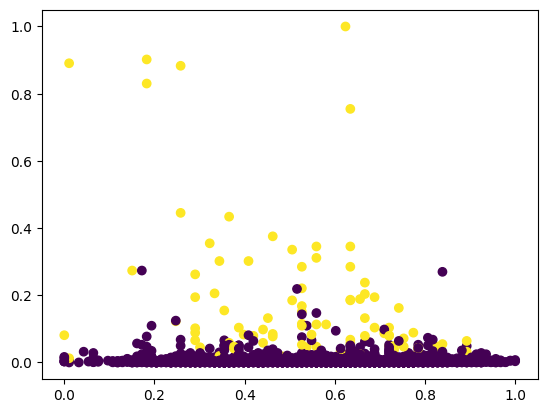

In [69]:
# plot original dataset (magenta = outliers, yellow = inliers)
plt.scatter(vals[:, 0], vals[:, 1],c=labels, cmap='viridis')

In [65]:
#KNN
from sklearn.neighbors import NearestNeighbors

def showElbow(D, K, eps_threshold):
  #KNN
  neigh = NearestNeighbors(n_neighbors=K)
  neigh.fit(D)
  distances= neigh.kneighbors(D)[0]
  distances = np.sort(distances[:, -1])

  plt.plot(distances)
  plt.axhline(y=eps_threshold, color='r', label=f'eps Threshold (eps={eps_threshold:.2f})')
  plt.xlabel('Index')
  plt.ylabel(f'{K}-Nearest Neighbor Distance')
  plt.title(f'Elbow Point Search k={K}')
  plt.legend()
  plt.show()

In [94]:

def showScatterRes(res, vals, K, eps):
  labels= [0] * len(vals)
  for i in res[0]:
      labels[i] = 1 # outliers

  for c in res[1]:
      for i in c:
          labels[i] = 0 # inliers

  plt.scatter(vals[:, 0], vals[:, 1],c=labels, cmap='viridis')
  plt.ylabel(f'Scatterplot colored data inliers=magenta, outliers=yellow')
  plt.title(f'Scatterplot cluster data colored k={K} eps={eps}')
  plt.show()

In [96]:
def printQuantitativeStats(res, vals):
    res_labels= [0] * len(vals)
    for i in res[0]:
        res_labels[i] = 1 # outliers

    for c in res[1]:
        for i in c:
            res_labels[i] = 0 # inliers

    precision = metrics.precision_score(labels, res_labels)
    recall = metrics.recall_score(labels, res_labels)
    f_score = metrics.f1_score(labels, res_labels)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F-score:", f_score)

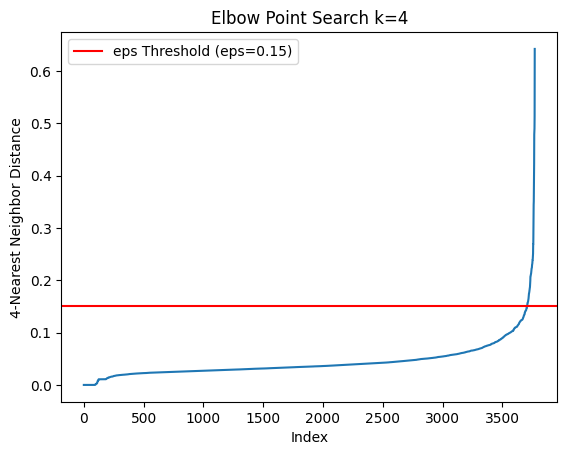

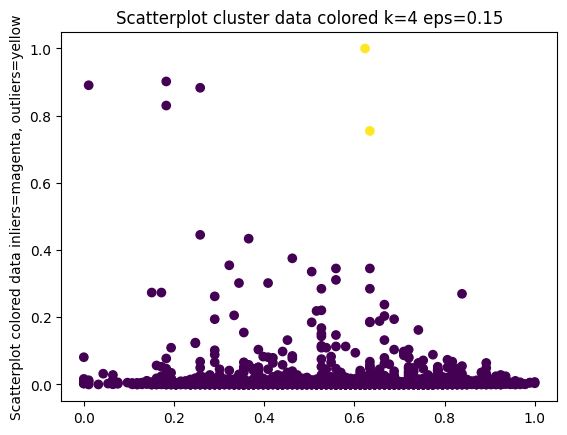

Precision: 0.5
Recall: 0.4
F-score: 0.4444444444444445


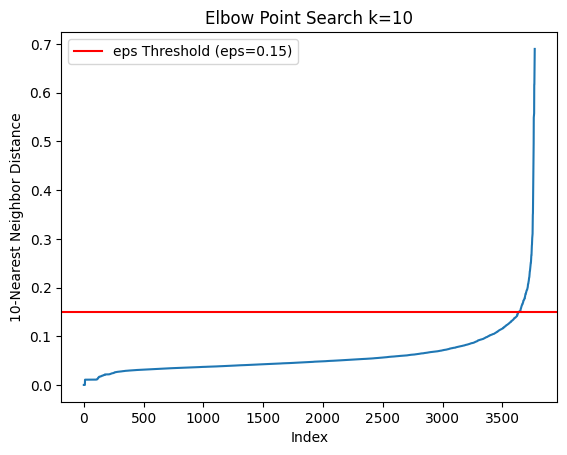

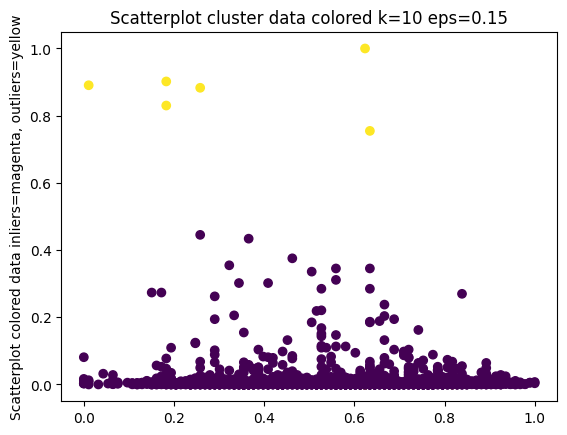

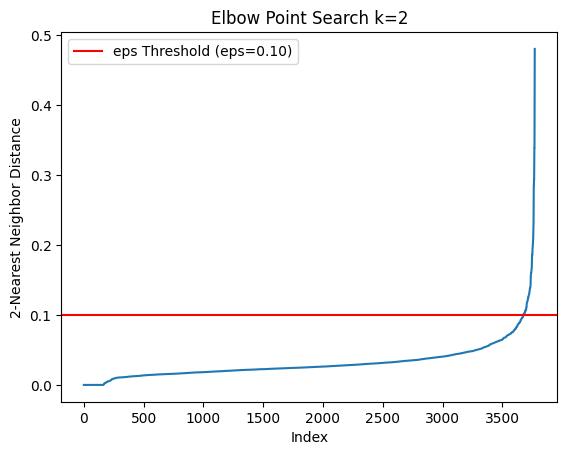

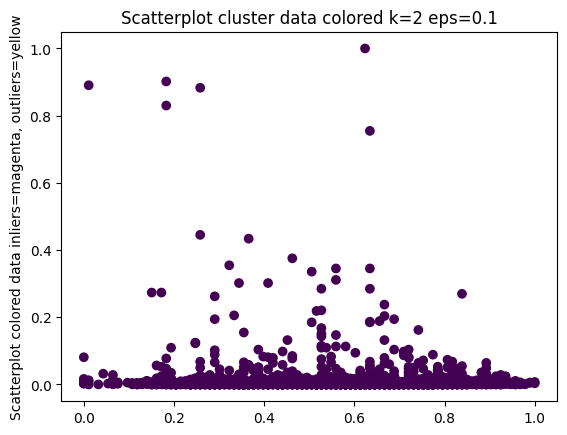

In [97]:
K=4
eps = 0.15
showElbow(vals, K, eps)
res = DBSCAN(vals, eps, K)
showScatterRes(res, vals, K, eps)
printQuantitativeStats(res, vals)


K=10
eps = 0.15
showElbow(vals, K, eps)
res = DBSCAN(vals, eps, K)
showScatterRes(res, vals, K,eps)
printQuantitativeStats(res, vals)

K=2
eps = 0.1
showElbow(vals, K,eps)
res = DBSCAN(vals, eps, K)
showScatterRes(res, vals, K, eps)
printQuantitativeStats(res, vals)


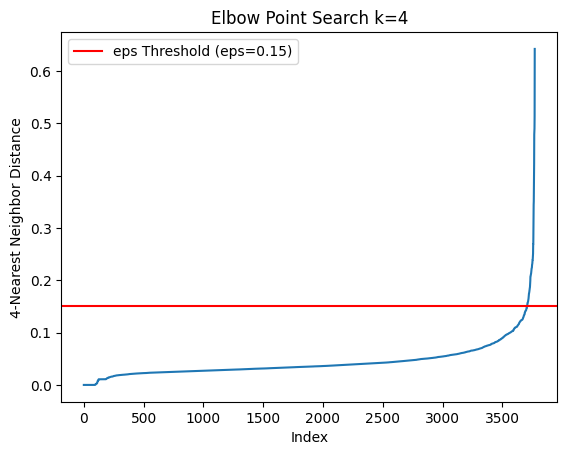

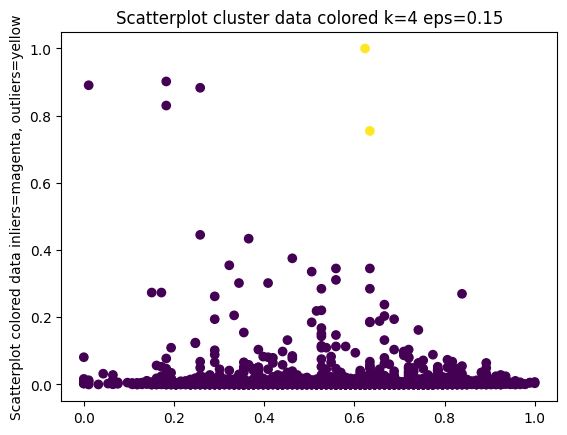

Precision: 0.5
Recall: 0.4
F-score: 0.4444444444444445


In [93]:
from sklearn import metrics



K=4
eps = 0.15
showElbow(vals, K, eps)
res = DBSCAN(vals, eps, K)
showScatterRes(res, vals, K, eps)
printQuantitativeStats(res, vals)
